In [2]:
# MIDTERM 1, PROBLEM 1
%matplotlib inline
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy import ndimage, misc
from scipy.linalg import toeplitz
np.set_printoptions(threshold=np.inf)
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

In [3]:
### Set up problem
# parameters
t0 = -5
tn = 99.5
ts = 12.0
n  = int(2*(tn-t0)+1)
t  = np.linspace(-5,99.5,n)
dt = 0.5
g0 = 1

# Define G
idx = int(np.argwhere(t==ts))
G = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        if (i >= j):
            G[i,j] = g0*(t[i]-t[j])*np.exp(-(t[i]-t[j])/ts)*dt


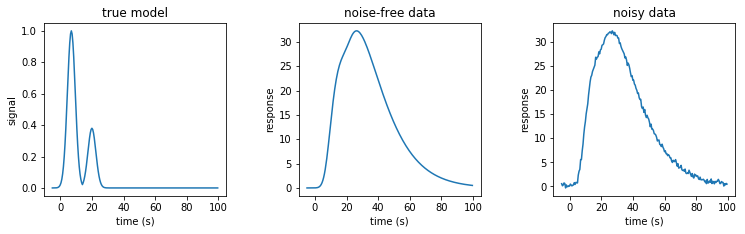

In [4]:
### Part a
# Make a true model that looks like the one in fig. 4.4
# use 2 gaussian functions
mt1 = norm.pdf(t, 7, 2.5)
mt1 = mt1/max(mt1) # max of peak is ~1
mt1 = mt1[0:38]
mt2 = norm.pdf(t, 20, 2.5)
mt2 = (mt2/max(mt2))*.38 # max of peak is ~0.38
mt2 = mt2[38:]
mt  = np.concatenate([mt1, mt2]) 

# Generate noise-free
dnf    = np.dot(G,mt)

# Generate noisy data s.t. sigma=1% of peak measurement
np.random.seed(0)
std  = max(dnf)*0.01
dn    = dnf+np.random.normal(0.0,std,n)

# plot
ax=plt.subplot(131)
plt.subplots_adjust(left=0.4, bottom=0.4, right=2, top=1.0, hspace=0.4, wspace=0.4)
plt.plot(t,mt)
plt.title('true model')
ax.set_xlabel("time (s)")
ax.set_ylabel("signal")

ax=plt.subplot(132)
plt.plot(t,dnf)
ax.set_xlabel("time (s)")
ax.set_ylabel("response")
plt.title('noise-free data')

ax=plt.subplot(133)
plt.plot(t,dn)
ax.set_xlabel("time (s)")
ax.set_ylabel("response")
plt.title('noisy data')

plt.show()

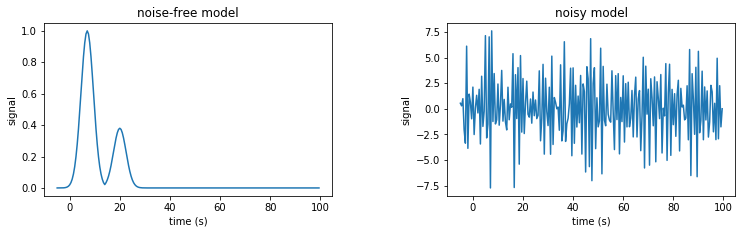

In [5]:
### Part b
# SVD 
[u, s, v] = np.linalg.svd(G)
v  = v.T
p  = np.linalg.matrix_rank(G)
up = u[:, 0:p]
vp = v[:, 0:p]
sp = s[0:p]

sm = np.eye(p,p)
for i in range(p):
    sm[i,i] = sp[i]
smi = np.linalg.inv(sm)

# Recover noise-free and noisy data
Gt        = np.dot(np.dot(vp,smi), up.T)
mest_nf   = np.dot(Gt, dnf)
mest_n    = np.dot(Gt, dn)

# plot
ax=plt.subplot(121)
plt.subplots_adjust(left=0.4, bottom=0.4, right=2, top=1.0, hspace=0.4, wspace=0.4)
plt.plot(t,mest_nf)
ax.set_xlabel("time (s)")
ax.set_ylabel("signal")
plt.title('noise-free model')

ax=plt.subplot(122)
plt.plot(t,mest_n)
ax.set_xlabel("time (s)")
ax.set_ylabel("signal")
plt.title('noisy model')
plt.show()

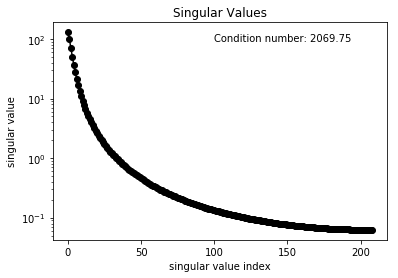

In [6]:
### Part c
# condition number
Cnp = sp[0]/sp[-1]
cnps = str(Cnp)
# Plot singular values
ax=plt.subplot(111)
xa = np.arange(s.shape[0]-1)
plt.semilogy(xa, sp, 'ok', xa, sp, 'k')
ax.set_xlabel("singular value index")
ax.set_ylabel("singular value")
plt.title('Singular Values')
plt.annotate('Condition number: '+cnps[0:-9],(100,90))
plt.show()

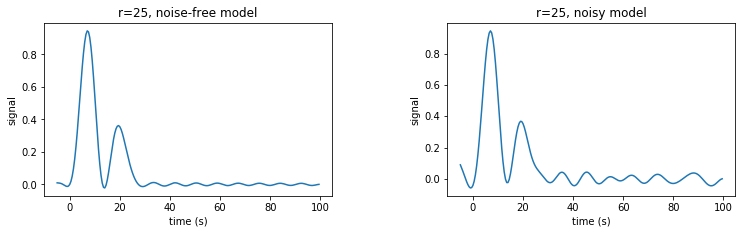

In [7]:
### Part d
# SVD with only 25 largest SVs 
r = 25
ur = u[:, 0:r]
vr = v[:, 0:r]
sr = s[0:r]

srm = np.eye(r,r)
for i in range(r):
    srm[i,i] = sr[i]
srmi = np.linalg.inv(srm)

Gt_r        = np.dot(np.dot(vr,srmi), ur.T)
mest_nf_r   = np.dot(Gt_r, dnf)
mest_n_r    = np.dot(Gt_r, dn)

# plot
ax=plt.subplot(121)
plt.subplots_adjust(left=0.4, bottom=0.4, right=2, top=1.0, hspace=0.4, wspace=0.4)
plt.plot(t,mest_nf_r)
ax.set_xlabel("time (s)")
ax.set_ylabel("signal")
plt.title('r=25, noise-free model')

ax=plt.subplot(122)
plt.plot(t,mest_n_r)
ax.set_xlabel("time (s)")
ax.set_ylabel("signal")
plt.title('r=25, noisy model')
plt.show()

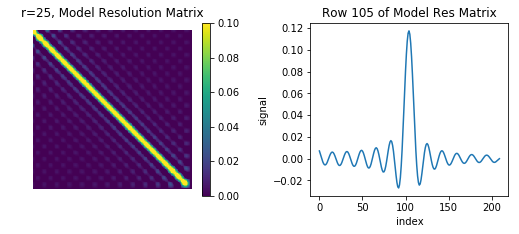

In [8]:
### Part e
# model resolution matrix (Gsvd*G)
Rm    = np.flipud(np.dot(Gt_r,G))
row   = int(n/2)
xsec  = Rm[row,:]
xxsec = np.arange(s.shape[0])

# plot
ax=plt.subplot(121)
plt.subplots_adjust(left=0.4, bottom=0.4, right=1.5, top=1.0, hspace=0.4, wspace=0.4)
plt.pcolor(Rm, vmin=0, vmax=.1)
plt.axis('off')
plt.axis('equal')
plt.title('r=25, Model Resolution Matrix')
plt.colorbar()

ax=plt.subplot(122)
plt.plot(xxsec,xsec)
ax.set_xlabel("index")
ax.set_ylabel("signal")
plt.title('Row '+str(row)+' of Model Res Matrix')
plt.show()


plt.show()


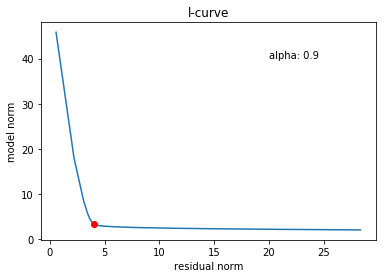

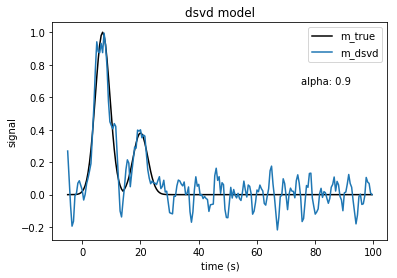

In [9]:
#### part f
# Dampened SVD 
sp2  = sp**2 # singular values squared

ai = np.arange(0, 30, 0.1)
an = ai.shape[0]

L = np.eye(n) #weighting matrix is identity, in this case (Damped LSQ w/SVD)
l2r    = np.zeros(an)
l2m  = np.zeros(an)
for i in range(an):
    a2       = ai[i]**2
    Fd1      = (sp2/(sp2+a2))
    Fd2      = np.eye(p,p)
    Fd       = Fd2*Fd1
    Gt_dsvd  = np.dot(np.dot(vp,np.dot(Fd,smi)), up.T)
    mi       = np.dot(Gt_dsvd, dn)
    di       = np.dot(G, mi)
    l2r[i]   = np.sqrt(np.sum((dn-di)**2)) # l2 norm of model residual
    lm       = np.dot(L,mi)
    l2m[i]   = np.sqrt(np.sum((lm)**2)) # l2 norm of model residual
    
# plot l-curve 
abest = 9
ax=plt.subplot(111)
plt.plot(l2r, l2m)
plt.plot(l2r[abest], l2m[abest],"ro")
ax.set_xlabel("residual norm")
ax.set_ylabel("model norm")
plt.title('l-curve')
plt.annotate('alpha: '+str(ai[abest]),(20,40))
plt.show()

# use preferred value for alpha
a         = ai[abest]
Fd1       = (sp2/(sp2+(a**2)))
Fd2       = np.eye(p,p)
Fd        = Fd2*Fd1
Gt_dsvd   = np.dot(np.dot(vp,np.dot(Fd,smi)), up.T)
mest_dsvd = np.dot(Gt_dsvd, dn)
dest_dsvd = np.dot(G,mest_dsvd)

# plot preferred model
ax=plt.subplot(111)
plt.plot(t, mt, color='black')
plt.plot(t,mest_dsvd)
ax.set_xlabel("time (s)")
ax.set_ylabel("signal")
plt.title('dsvd model')
plt.annotate('alpha: '+str(a),(75,.68))
plt.legend(('m_true', 'm_dsvd'))
plt.show()


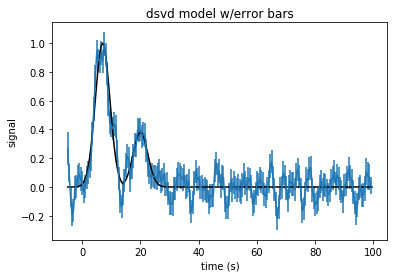

In [10]:
### part g
# data cov matrix
var = std**2  #var = std^2
Cd  = np.eye(n)*var
Cm  = np.dot(Gt_dsvd, np.dot(Cd, Gt_dsvd.T))
eb  = np.sqrt(np.diagonal(Cm)) 

ax=plt.subplot(111)
plt.plot(t, mt, color='black')
ax.errorbar(t,mest_dsvd, yerr=eb)
ax.set_xlabel("time (s)")
ax.set_ylabel("signal")
plt.title('dsvd model w/error bars')
plt.show()

# The true model is generally within the error bars, but do not everywhere. Perhaps error bars should be 2-sigma.  


In [11]:
# Part h
resid = dn-np.dot(G, mest_dsvd)
Cdi   = np.linalg.inv(Cd)
chi2  = np.dot(resid.T, np.dot(Cdi, resid))
print('Chi squared: ', int(np.round(chi2)))

# this value for chi squared is not good. It should be approx equal to the degrees of freedom, 
# which is n-m=0. This value for chi squared is much larger. 


Chi squared:  158
